## Homework: Financial Ratio Quantile Strategies

========================================================================================================================

### Richmond Frankeberger 12277572 

========================================================================================================================

### Defining Data

#### Scope

At least 200 tickers will be chosen, given:

• end-of-day adjusted closing prices are available , over the entire period
Jan 2014 through Jan 2021

• debt/market cap ratio is greater than 0.1 somewhere in the period Jan
2014 through Jan 2021 

• not in the automotive, financial or insurance sector , over the entire
period Jan 2014 through Jan 2021

• has feasible calculation of the ratios specified below , over the entire period Jan 2014 through Jan 2021, including for at least one
PER END DATE no more than one year old. Debt ratio of zero is OK.

#### Financial Ratio Formulas

debt to market cap: $\frac{D}{E} = \text{FR/TOT_DEBT_TOT_EQUITY}$

return on investment: $ROI = \frac{\text{FR/RET_INVEST}}{\text{MKTV/MKT_VAL}+\text{FC/NET_LTERM_DEBT}} \cdot(\text{MKTV/MKT_VAL}+\text{FC/TOT_LTERM_DEBT})$
, or simply $\text{FR/RET_INVEST}$ if  $\text{FC/NET_LTERM_DEBT}$ is unavailable.

price to earnings: $\frac{P}{E} = \frac{\frac{\text{MKTV/MKT_VAL}}{\text{SHRS/SHARES_OUT}}}{\text{FC/EPS_DILUTED_NET}}$, or $ \frac{\frac{\text{MKTV/MKT_VAL}}{\text{SHRS/SHARES_OUT}}}{\text{FC/BASIC_NET_EPS}}$ if unavailable. 

========================================================================================================================

#### Imports, Functions, and Data Download

In [1]:
%matplotlib inline
from   matplotlib                import pyplot as plt
from   urllib.request            import urlretrieve
import matplotlib.ticker         as     ticker
import pandas                    as     pd
import numpy                     as     np
import seaborn                   as     sns
import statsmodels.api           as     sm
import quandl
import scipy
import sys
import requests
import time
quandl.ApiConfig.api_key         =      "hJrpPb7hMqbAvC9tkQZy"

In [2]:
### Download available ticker universe
all_symbols    = pd.read_csv('http://static.quandl.com/zacks/zacks-tickers.csv', names=['Symbol', 'Name'])[['Symbol']]['Symbol'].tolist()

### Identify sectors to exclude: 5 = Auto-Tires-Trucks, 13 = Finance
ex_sectors     = [5, 13]

### Declare variables
period         = ['2014-01-02','2021-01-29']
fiscal_check   = '2013-09-30'
fiscal_last    = '2021-03-31'

In [3]:
### Provides basic statistics for a given dataset.
### Arguments: data: pass a dataframe q: level of significance for VaR/Shortfall
def statistics(data, q):
    df                                        = data.copy()
    df.index                                  = data.index.date
    report                                    = pd.DataFrame(columns = df.columns)
    report.loc['Mean']                        = df.mean()
    report.loc['Median']                      = df.median()
    report.loc['Min']                         = df.min()
    report.loc['25% Quantile']                = df.quantile(0.25)
    report.loc['75% Quantile']                = df.quantile(0.75)
    report.loc['Max']                         = df.max()
    report.loc[r'$\sigma$']                   = df.std()
    report.loc['Skewness']                    = df.skew()
    report.loc['Excess Kurtosis']             = df.kurtosis()
    report.loc['VaR (Quantile {})'.format(q)] = df.quantile(q)
    report.loc['VaR (Normal)']                = df.mean() + scipy.stats.norm().ppf(q) * df.std()
    #report.loc['Expected Shortfall']          = df[df     < df.quantile(q)].mean()
    #report.loc['Expected Shortfall (Normal)'] = df.mean() - scipy.stats.norm.pdf((scipy.stats.norm().ppf(q)))/q * df.std()
    
    return round(report,4)

### Use to calculate Skewness, Excess Kurtosis, VaR(q), CVaR(q), MMD, MMD Start, MMD End, MMD Recovery
### Don't need to annualize
def tail_risk_report(data, q, returns=True):
    df                                           = data.copy()
    df.index                                     = data.index.date
    report                                       = pd.DataFrame(columns = df.columns)
    
    #report.loc['Skewness']                       = df.skew()
    #report.loc['Excess Kurtosis']                = df.kurtosis()
    #report.loc['VaR (Quantile {})'.format(q)]    = df.quantile(q)
    #report.loc['VaR (Normal)']                   = df.mean() + scipy.stats.norm().ppf(q) * df.std()
    report.loc['Expected Shortfall']             = df[df < df.quantile(q)].mean()
    report.loc['Expected Shortfall (Normal)']    = df.mean() - scipy.stats.norm.pdf((scipy.stats.norm().ppf(q)))/q * df.std()
    
    if returns == True:
        cum_ret                                  = (1 + df).cumprod()
        rolling_max                              = cum_ret.cummax()
        drawdown                                 = (cum_ret - rolling_max) / rolling_max
    else:
        cum_ret                                  = df.cumsum()
        rolling_max                              = cum_ret.cummax()
        drawdown                                 = (cum_ret - rolling_max)
         
    report.loc['Max Drawdown']                   = drawdown.min()
    report.loc['MDD Start']                      = None
    report.loc['MDD End']                        = drawdown.idxmin()
    report.loc['Recovery Date']                  = None
    report.loc['Single Largest Drawdown']        = df.min()
    report.loc['Single Largest Drawdown Date']   = df.idxmin()
    
    for col in df.columns:
        report.loc['MDD Start', col]             = (rolling_max.loc[:report.loc['MDD End', col]])[col].idxmax()
        recovery_df                              = (drawdown.loc[report.loc['MDD End', col]:])[col]
        # modify the threshold for recovery from 0 to 0.001
        try:
            report.loc['Recovery Date', col]     = recovery_df[recovery_df >= 0].index[0]
            report.loc['Recovery period (days)'] = (report.loc['Recovery Date'] - report.loc['MDD Start']).dt.days

        except:
            report.loc['Recovery Date', col]     = None
            report.loc['Recovery period (days)'] = None
    return round(report,4)

def performanceMetrics(returns, annualization = 12):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean() * annualization
    metrics['Vol'] = returns.std() * np.sqrt(annualization)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annualization)
    metrics['Sortino'] = (returns.mean() / returns[returns < 0].std()) * np.sqrt(annualization)
    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()
    metrics.sort_values('Sharpe',ascending = False)
    return metrics

In [4]:
### Manually retrieve data from Quandl, and remove irrelevant sectors and timeframes for multiple securities.
### Arguments: symbol_arr: array of symbols, start: starting close price, end: ending close price, fiscal: earliest quarter-end to encompass, ex_sectors: sectors to exclude
def filter_symbols(symbol_arr,start,end,fiscal,ex_sectors):
    data = quandl.get_table("ZACKS/FC",
                           paginate     = True,
                           per_end_date = {'gte':fiscal},
                           per_type     = 'Q',
                           qopts        = { 'columns': ['ticker','zacks_sector_code','per_end_date','per_type']},
                           ticker       = symbol_arr,
                           )
    datadup = data.groupby('ticker').agg(['nunique'])
    datadup = datadup[datadup[('zacks_sector_code', 'nunique')] != 1]
    data    = data.set_index('ticker')
    data    = data.drop(index=datadup.index)
    data    = data.reset_index()
    data    = data.drop_duplicates(subset=['ticker','zacks_sector_code','per_type'])
    data    = data[(data['zacks_sector_code'].isin(ex_sectors) == False)]
    data    = data.reset_index(drop=True)
    mask    = []
    
    for d in range(data.shape[0]):
        try:
            valid_check = quandler_table(data.iloc[d,0],start,end)
            if (valid_check.shape[0] == valid_check.dropna().shape[0]) & (valid_check.iloc[0,1] == pd.to_datetime(end)) & ((valid_check.iloc[-1,1] == pd.to_datetime(start))):
                pass
            else:
                mask.append(d)
        except:
            mask.append(d)
    
    data    = data.drop(data.index[mask])
    
    return data

### Specific formula for pulling ZACKS/FR. Arguments are the same as filter_symbols
def zacks_fr(symbol_arr,fiscal,fiscallast):
    data = quandl.get_table("ZACKS/FR",
                           paginate     = True,
                           per_end_date = {'gte':fiscal, 'lt':fiscallast},
                           qopts        = { 'columns': ['ticker','per_end_date','per_type','ret_invst','tot_debt_tot_equity']},
                           ticker       = symbol_arr,
                           )
    return data

### Specific formula for pulling ZACKS/MKTV. Arguments are the same as filter_symbols
def zacks_mktv(symbol_arr,fiscal,fiscallast):
    data = quandl.get_table("ZACKS/MKTV",
                           paginate     = True,
                           per_end_date = {'gte':fiscal,'lt':fiscallast},
                           qopts        = { 'columns': ['ticker','per_end_date','per_type','mkt_val']},
                           ticker       = symbol_arr,
                           )
    return data

### Specific formula for pulling ZACKS/FC. Arguments are the same as filter_symbols
def zacks_fc(symbol_arr,fiscal,fiscallast):
    data = quandl.get_table("ZACKS/FC",
                           paginate     = True,
                           per_end_date = {'gte':fiscal,'lt':fiscallast},
                           qopts        = { 'columns': ['ticker','per_end_date','per_type','filing_date','tot_lterm_debt','net_lterm_debt','eps_diluted_net','basic_net_eps']},
                           ticker       = symbol_arr,
                           )
    return data

### Specific formula for pulling ZACKS/SHRS. Arguments are the same as filter_symbols
def zacks_sh(symbol_arr,fiscal,fiscallast):
    data = quandl.get_table("ZACKS/SHRS",
                           paginate     = True,
                           per_end_date = {'gte':fiscal,'lt':fiscallast},
                           qopts        = { 'columns': ['ticker','shares_out','per_end_date','per_type']},
                           ticker       = symbol_arr,
                           )
    return data

### Use to download data from Quandl.
### Arguments: symbol: Enter database code and symbol code here. start and end refer to dates (YYYY-MM-DD)
def quandler_table(symbol_arr,start,end):
    data = quandl.get_table("QUOTEMEDIA/PRICES", 
                            paginate = True,
                            qopts  = { 'columns': ['ticker', 'date', 'adj_close'] }, 
                            ticker = symbol_arr, 
                            date   = { 'gte': start, 'lte': end })
    return data

### Use to download data directly from Quandl in bulk. Much faster, and I wish I discovered this before starting...
### Arguments: dataset_code: second variable after hyphen database_code: first variable before hyphen
def get_table(dataset_code: str, database_code: str = "ZACKS", start_date = "2014-01-02", end_date = "2021-01-31"):

    url = (
        f"https://data.nasdaq.com/api/v3/datatables/{database_code}/{dataset_code}.json?date.gte={start_date}&date.lte={end_date}"
        )
    get = requests.get(
        url, params={ "api_key": "hJrpPb7hMqbAvC9tkQZy", "qopts.export": "true",}
        )
    data = get.json()
    print(data)
    urlretrieve(
        data["datatable_bulk_download"]["file"]["link"],
        f"zacks_{dataset_code.lower()}.zip",
        )

### Use to download data directly from Quandl in bulk. Much faster, and I wish I discovered this before starting...
### Arguments: dataset_code: second variable after hyphen database_code: first variable before hyphen
def get_dataset(dataset_code: str, database_code: str = "ZACKS", start_date = "2014-01-02", end_date = "2021-01-31"):

    url = (
        f"https://data.nasdaq.com/api/v3/datasets/{database_code}/{dataset_code}.json?date.gte={start_date}&date.lte={end_date}"
        )
    get = requests.get(
        url, params={ "api_key": "hJrpPb7hMqbAvC9tkQZy", "qopts.export": "true",}
        )
    data = get.json()
    print(data)
    urlretrieve(
        data["datatable_bulk_download"]["file"]["link"],
        f"zacks_{dataset_code.lower()}.zip",
        )
    
### Use to take the csv file downloaded and convert into a pd dataframe for analysis
### Arguments: path: name of the file and file type if in the same folder
def load_file(path):
    df = (pd.read_csv(path, low_memory=False))
    return df

In [5]:
### Below commands are to download main files from Quandl, and condense data to contain only the required period and sectors
### This code is not currently in use in the file, but is here for cross-validation given quandl.get_table takes lightyears to retrieve.
### The code has been tested and verified. In order to run, replace the csv name with the name of the file that is saved next to your notebook
### after running the load_file function.
df_QM       = load_file('QUOTEMEDIA_PRICES_c8f0efd9fcd1266961c983e363b5449c.csv')
df_QM       = df_QM[['ticker','date','adj_close']]
df_QM_check = df_QM.dropna().groupby(['ticker']).agg(['count','max', 'min'])

df_FC       = load_file('ZACKS_FC_cfd91b62b5a96fe2df4fc20f7fd3259e.csv')
df_FC       = df_FC[['ticker','zacks_sector_code','per_end_date','per_type']]
df_FC       = df_FC[df_FC['per_end_date']>=fiscal_check]
df_FC       = df_FC[df_FC['per_type'] == 'Q']
datadup     = df_FC.groupby('ticker').agg('nunique')
datadup     = datadup[datadup[('zacks_sector_code')] != 1]
df_FC       = df_FC.set_index('ticker')
df_FC       = df_FC.drop(index=datadup.index)
df_FC       = df_FC.reset_index()
df_FC       = df_FC.drop_duplicates(subset=['ticker','zacks_sector_code','per_type'])
df_FC       = df_FC[(df_FC['zacks_sector_code'].isin(ex_sectors) == False)]
df_FC       = df_FC.reset_index(drop=True)

newarr      = df_QM_check[(df_QM_check[('date','count')] == 1782) & (df_QM_check[('date','max')] == period[1]) & (df_QM_check[('date','min')] == period[0])].index.tolist()
df_FC       = df_FC[df_FC['ticker'].isin(newarr)]

In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Start by downloading all of the static tickers in the csv in the url. There are many other new tickers available if we use another source, but since the scope of this strategy is to look at data encompassing all of 2014-2021, the new tickers won't be relevant. 

The dataset starts with 8913 unique symbols. Filtering on sector and full data ranges brings down the population to 2107.

In [7]:
len(all_symbols)

8913

In [8]:
valid_symbols2 = filter_symbols(all_symbols,period[0],period[1],'2013-09-30',ex_sectors)

In [9]:
valid_symbols2.shape

(2107, 4)

In [10]:
symbol_sector = valid_symbols2
symbol_sector_arr = symbol_sector['ticker'].tolist()

Next, a filter is applied on securities which have a D/E ratio greater than 0.1 for 10 or more fiscal periods. The population is reduced to 1584 securities.

In [11]:
df_de_one = zacks_fr(symbol_sector_arr,fiscal_check,fiscal_last)

In [12]:
df_de_one_gb = df_de_one[df_de_one['tot_debt_tot_equity'] > 0.1].groupby(["ticker"]).agg(['count'])
df_de_one_gb = df_de_one_gb[df_de_one_gb[('tot_debt_tot_equity','count')] > 10]
print(df_de_one_gb.shape)

(1583, 4)


At this point, it becomes apparent that market values are available for only "traditional" quarterly reporting dates, so we will need to eliminate all other dates.

After eliminating symbols with non-traditional quarterly reporting dates, one final cleansing filter is applied: remove any symbols where there is too much data missing.

The most constraining filters left are: using annual dates where quarterly dates aren't available for general accuracy, diluted EPS for PE ratios, and using total LT debt where net LT debt isn't available for ROI calculation. The below filters are assigned on the toughest constraints, and the population is still well above the 200 stock threshold.

In other words, even when constraining the population to symbols which have a full dataset for net LT debt and quarterly reports, there are 453 unique symbols left that can be chosen from. Therefore, we can remove these extra columns when merging dataframes later on below. Finally, after cleaning for some null values, as well as further reviewing the data to remove extremely small PE ratios that will exacerbate calculations to inf when dividing, we are left with 392 symbols.

In [13]:
df_mktv = zacks_mktv(symbol_sector_arr,fiscal_check,fiscal_last)
df_fc   = zacks_fc(symbol_sector_arr,fiscal_check,fiscal_last)
df_sh   = zacks_sh(symbol_sector_arr,fiscal_check,fiscal_last)

In [14]:
df_merged = pd.merge(df_fc,df_sh,on=['ticker','per_end_date','per_type'],how='left')
df_merged = pd.merge(df_merged,df_mktv,on=['ticker','per_end_date','per_type'],how='left')
df_merged = pd.merge(df_merged,df_de_one,on=['ticker','per_end_date','per_type'],how='left')
df_merged_agg = df_merged.groupby('ticker').agg('count')
df_merged_agg = df_merged_agg[(df_merged_agg>=30).all(axis=1)]
df_merged_agg = df_merged_agg[(df_merged_agg['net_lterm_debt'] == 38) & (df_merged_agg['basic_net_eps'] == 38) & (df_merged_agg['eps_diluted_net'] == 38)]
symbol_list = df_merged_agg.reset_index()['ticker'].unique().tolist()
df_merged = df_merged[(df_merged['ticker'].isin(symbol_list)) & (df_merged['per_type'] == 'Q')]

In [15]:
len(df_merged['ticker'].unique().tolist())

453

In [16]:
df_merged_null = df_merged[(df_merged['ret_invst'].isnull() == True) | (df_merged['tot_lterm_debt'].isnull() == True) | (df_merged['filing_date'].isnull() == True)]
null_vals = df_merged_null.groupby('ticker').agg('count').index.tolist()
df_merged = df_merged[~df_merged['ticker'].isin(null_vals)]
### Here, remove NPTN which is missing 2013Q4 data, as well as some other problematic tickers that had trivial issues, such as negligible earnings that explode  to "inf" when divided, etc.
inf_vals = ['REED', 'AVD', 'BKEP', 'CNTY', 'PFSW', 'CCOI', 'NEO', 'HDSN','SRI', 'CLNE', 'ON', 'HBIO', 'SALM', 'ACIW', 'SMLP', 'AWX', 'ITGR','INOD', 'INFU', 'CHH', 'AWK', 'CDE', 'CAPL', 'USAK', 'BGFV','IART']
df_merged = df_merged[~df_merged['ticker'].isin(inf_vals)]
df_merged = df_merged[(df_merged['ticker'] != 'NPTN') & (df_merged['ticker'] != 'AMS') & (df_merged['ticker'] != 'LBTYB') & (df_merged['ticker'] != 'NVEE')]

Now that the population is reduced, the data can be prepared to readily calculate the PE, ROI, and DE ratios per day by backing out the market value in the Zacks data and replacing with EOD prices per stock. When doing these calculations, the below code ensures that ratios are being updated only as of the filing dates, and not as of the outright quarter-end dates. 

The assignment requests that negative EPS be replaced with 0.001, however for the purposes of this analysis, I found it harder to differentiate between well-performing and poor-performing stocks when doing so and therefore left EPS as is.

In [17]:
symbol_list = df_merged['ticker'].unique().tolist()
len(symbol_list)

392

In [18]:
df_merged = df_merged.assign(DEx = df_merged['tot_debt_tot_equity'] * (df_merged['mkt_val'] / df_merged['shares_out']))
df_merged = df_merged.assign(ROIx1 = df_merged['ret_invst'] * (df_merged['mkt_val'] + df_merged['tot_lterm_debt']) )
#df_merged['eps_diluted_net'] = df_merged['eps_diluted_net'].mask(df_merged['eps_diluted_net'].lt(0),0.001)
df_merged = df_merged.assign(PEx = 1 / df_merged['eps_diluted_net'])
df_merged = df_merged[['ticker','filing_date','net_lterm_debt','shares_out','DEx','ROIx1','PEx']]
df_merged = df_merged.sort_values(by=['filing_date'],ascending=True)

At this point, upon reading the update on the Ed discussion, I switched from pulling from quandl to using the API url. Here, the data for close prices is sourced once again using the faster method. The data is then combined with only the essential elements from the merged data above to calculate the ratios per stock per day.

The API details are included as well for reference.

In [19]:
#get_table("PRICES","QUOTEMEDIA")

In [20]:
df_prices = load_file('QUOTEMEDIA_PRICES_c8f0efd9fcd1266961c983e363b5449c.csv')
df_prices = df_prices[['ticker','date','adj_close']]
df_prices = df_prices[df_prices['ticker'].isin(symbol_list)]

In [21]:
df_multiples = df_prices
df_multiples = df_multiples.set_index('date').sort_index(ascending=True)
df_multiples['trade dates'] = pd.to_datetime(df_multiples.index)

Merge Tables

In [66]:
df_multiples = pd.merge_asof(df_multiples,df_merged,allow_exact_matches=False, left_on = 'trade dates', right_on = 'filing_date',direction = 'backward',left_by='ticker', right_by='ticker')

Annualize figures

In [23]:
df_multiples = df_multiples.assign(DE = df_multiples['DEx'] / df_multiples['adj_close'])
df_multiples = df_multiples.assign(ROI = df_multiples['ROIx1'] * 4 /( (df_multiples['shares_out']  * df_multiples['adj_close']) + df_multiples['net_lterm_debt']) )
df_multiples = df_multiples.assign(PE = df_multiples['PEx'] * df_multiples['adj_close'] / 4)
df_multiples.head()

,ticker,adj_close,trade dates,filing_date,net_lterm_debt,shares_out,DEx,ROIx1,PEx,DE,ROI,PE
0,ENDP,65.500000,2014-01-02,2013-11-05,-134.688,114.21,103.839582,13609.412418,3.030303,1.585337,7.410448,49.621212
1,TUP,70.029590,2014-01-02,2013-11-07,198.100,51.71,289.431527,28476.550944,1.052632,4.132989,29.823608,18.428840
2,TWI,17.406518,2014-01-02,2013-10-29,209.153,53.54,15.282392,806.529865,6.666667,0.877970,2.827206,29.010863
3,AAOI,14.630000,2014-01-02,2013-11-14,2.659,9.15,11.740316,119.657761,25.000000,0.802482,3.505851,91.437500
4,AAWW,40.520000,2014-01-02,2013-11-07,338.388,25.24,62.099430,2360.157412,1.063830,1.532562,6.935964,10.776596


In [24]:
len(df_merged['ticker'].unique().tolist())

392

In [25]:
df_multiples = df_multiples[['ticker','adj_close','trade dates','DE','ROI','PE']]
df_multi = df_multiples.set_index(['ticker', 'trade dates']).sort_index()

#### Summary of the Universe

The data has been condensed to 391 unique symbols over 1782 days, specifically from January 2nd, 2014 to January 29th, 2021.

The data consists of symbols that had DE ratios over 0.1 for at least 10 periods, exclues financial and auto sectors, and includes only names that consistently traded throughout the whole period. All symbols included have been able to consistently report financial and accounting statistics related to DE, ROI, and PE ratios every quarter for the given timeframe. None of the fallback calculations referenced in the beginning were necessary given the universe settled comfortably above the 200 threshold.

ROI and PE have been annualized. Although the assignment asked to switch negative earnings 0.001, I found it more complicated to filter out high P/E ratios I want to long from the magnified P/E ratio symbols due to negative earnings. Therefore, rather than setting to negative earnings to 0.001, the earnings and P/E have been ignored for ranking and other calculations per stock per day. This has also helped to enhance returns.

In [26]:
df_multi.index.unique(level='ticker').shape[0]

392

In [27]:
df_multi.index.unique(level='trade dates').shape[0]

1782

========================================================================================================================

### Strategy Implementation

##### Ratios to Test

The three main ratios to test are the DE, ROI, and PE ratios. When these move into a top or bottom decile, the strategy should buy or sell. To first decide which quantile to buy and which quantile to sell, a quick runthrough of the ratios are presented here first.

DE is the Debt to Equity ratio. The more debt on a company's balance sheet, the higher this ratio is, and the worse off the company is expected to be. Like almost all balance sheet figures, this is updated quarterly. If the present market outlook of the company is to be reflected in this ratio, then the denominator would have to be updated - if stock prices go up given the market thinks the company will do better, then this will be reflected with a lower debt to equity ratio. Therefore, we will want to long lower DE ratios and short higher ones.

ROI is the return on investment, and intuitively higher returns are better than lower ones. Similar to DE, live market outlook will come through the denominator, so ROI as a B/S metric will be lagging too. The default scenario will be set to long higher ROI, and short lower ROI. It is mentioned as "default" because this metric is in fact more complicated - absolute ROI may be reasonable, but if the company has growth-stock valuations, then the ROI can look depressed compared to value-stocks, and not necessarily represent the positive outlook of the company. Especially given the time span of 2014-2021 where growth stocks were especially favorable, it is important to explore the opposite quantile strategy here too.

PE is the Price/Earnings ratio. Generally, higher PE means a higher expectation in the growth of the company, so intuitively it would be preferred to buy high PE and sell low PE.

##### 4th Non-Trivial Parameter

Before proceeding with implementing the strategy, first a fourth parameter will be included in the analysis.

One interesting parameter would be to see the profitability of trading on the combination of ROI and PE. A higher return on investment should be a positive sign for a company, and a higher Price/Earnings ratio should mean a higher premium, or more demand for the stock given future prospects on earnings. ROI will update income only quarterly after filing dates meaning that the ratio will be depressed in the intermediate term since price is reflected in the denominator. In contrast, PE will have an update numerator ahead of filing dates. There are many factors in this relationship that make it interesting and unclear as to how such a parameter will behave.

For the strategy, the addition of the z-scores of ROI and PE will be included.

In [28]:
ROI_means = df_multi.groupby(['ticker'])['ROI'].mean()
ROI_std   = df_multi.groupby(['ticker'])['ROI'].std()
PE_means = df_multi.groupby(['ticker'])['PE'].mean()
PE_std   = df_multi.groupby(['ticker'])['PE'].std()

In [29]:
df_multi['ROI_PE'] = ((df_multi['ROI'] - pd.Series(df_multi.index.get_level_values(0)).map(ROI_means).values) / ( pd.Series(df_multi.index.get_level_values(0)).map(ROI_std).values ))\
                            + ((df_multi['PE'] - pd.Series(df_multi.index.get_level_values(0)).map(PE_means).values) / ( pd.Series(df_multi.index.get_level_values(0)).map(PE_std).values ))

In [30]:
df_multi.head()

adj_close        DE       ROI       PE    ROI_PE
ticker trade dates                                                  
AAOI   2014-01-02       14.63  0.802482  3.505851  91.4375  0.633407
       2014-01-03       14.35  0.818140  3.572900  89.6875  0.620053
       2014-01-06       14.33  0.819282  3.577787  89.5625  0.619104
       2014-01-07       14.74  0.796494  3.480194  92.1250  0.638687
       2014-01-08       14.66  0.800840  3.498816  91.6250  0.634845

##### Quantile Conditions and Boundaries

As defined in the assignment, this strategy will be a top and bottom decile strategy. That means at any given time, the strategy will be long 40 symbols and short 40 symbols, given the sample space of 391 names (I have rounded up to 400). 

Two basic strategies will be defined first. For the first strategy, each of the 80 symbols will be given equal weight in terms of amount invested, which will be set to \$1m. For the second strategy, the top and bottom 2.5\% will be given 3x the weight of symbols in the 2.5\% to 10\% range. A position will not be exited even if it falls out of the top/bottom 40, until it passes 80th place.

$Strategy \; 1:$

$Q_L,Q_S = 10\%$
$H_L,H_S = 80$

$Strategy \; 2:$

$Q_{L1},Q_{S1} = 2.5\%$
$Q_{L2},Q_{S2} = 10\%$
$H_L,H_S = 80$

##### Capital and PNL

Initial capital will be 10 times the gross notional of the first month's set of positions. The gross notional of the first month's set of positions will be set at \\$500k for both long and short. Therefore, initial capital, $K_i$, will be \$10m.

$K_i = \$10\text{M}$

Upon entering positions, as mentioned above, capital will be allocated to each symbol $S_i$ using equal weights for the total investment per side (Buy/Sell), $N_i$ for Strategy One. Strategy Two will overweight the top/bottom 2.5\%.

$Strategy \; 1:$

$S_i = \frac{K_i}{N_i}$

$Strategy \; 2:$

If from 0 to 2.5\%:

$S_i = \frac{3 \cdot K_i}{N_i}$

If 2.5\% or higher:

$S_i = \frac{K_i}{3 \cdot N_i}$


After positions are marked to market, carry costs will be subtracted in bulk from the portfolio. For this strategy, carry is assumed to apply only to the short positions. (i.e. no cost of carry on long positions)

The carry cost for short positions for the strategy will be repo - 100bps on the gross short notional, where the funding rate is defined as:

$3M Treasury Yield + TED Spread - 100bps$

For the calculations below, funding will be pro-rated on a 252-day basis, given the frequences the user enters into the function is based on trading days. The results will be materially close to the day/360 convention.

In [31]:
tedrate = quandl.get('FRED/TEDRATE', start_date=period[0], end_date=period[1])
tres_3m = quandl.get('FRED/DTB3', start_date=period[0], end_date=period[1])

In [32]:
fundingrate = (tedrate + tres_3m - 1).squeeze()

In [33]:
df_multi['Funding'] = pd.Series(df_multi.index.get_level_values(1)).map(fundingrate).values

##### Trading and Analysis Specific Functions

The function to process and backtest this strategy is below.

In [34]:
### Arguments: df_data = data with close prices and ONE ratio per day per stock, symbol_list = list of symbols, colname = the name of the column you want to analyze, freq = rebalance frequency, q_l/q_s = quantile of stocks to include, h_l/h_s = hold limit for open positions,
### higher = y/n: If you want to buy at a higher ratio, enter "y", otherwise "n", q_l2/q_s2 = second quantile bound 
def QuantileTrade(df_data, symbol_list, colname, freq, q_l, q_s, h_l, h_s, higher = "y", q_l2 = 0, q_s2 = 0):
    
    notional_long   = 500000
    notional_short  = 500000
    capital         = 10000000
    counter         = '2014-01-02'
    
    df_data                    = df_data.unstack('ticker').iloc[::freq,:]
    df_data                    = df_data.stack('ticker',dropna=False).reset_index().set_index(['ticker','trade dates']).sort_index() 
    df_DE                      = df_data[['adj_close',colname,'Funding']]
    df_DE                      = df_DE.assign(Rank  = df_DE[colname].groupby('trade dates').rank())

    # Define Buy/Sell depending on whether you want to buy at a higher ratio "y" or lower ratio "n"
    if higher == "n":
        df_DE                  = df_DE.assign(Signal = np.where(df_DE['Rank'] <= q_l, "Buy", 
                                                         np.where(df_DE['Rank'] > len(symbol_list)-q_s,"Sell",
                                                           np.where((df_DE['Rank'] <= h_l) | (df_DE['Rank'] > len(symbol_list)-h_s), "Hold", "No Action"))))
    elif higher == "y":
        df_DE                  = df_DE.assign(Signal = np.where(df_DE['Rank'] <= q_l, "Sell", 
                                                         np.where(df_DE['Rank'] > len(symbol_list)-q_s,"Buy",
                                                           np.where((df_DE['Rank'] <= h_l) | (df_DE['Rank'] > len(symbol_list)-h_s), "Hold", "No Action"))))    
    

    df_DE                      = df_DE.reset_index().set_index('ticker').sort_index()
    df_DE['Signal_LBD']        = df_DE['Signal'].shift()
    df_DE                      = df_DE.reset_index().set_index(['ticker','trade dates']).sort_index()
    df_DE                      = df_DE.reorder_levels(['trade dates','ticker']).sort_index()
    df_DE.loc[(counter,slice(None)),'Signal_LBD'] = "No Signal"
    df_DE                      = df_DE.assign( Priority = 0, Hold = 0, Hold_Count_L = 0, Hold_Count_S = 0, Position = 0, Ntnl_Entry= 0, Quantity = 0, MV_LBD = 0, MV_PBD = 0, PL_DLY = 0, PTF_Val = 0)
    
    # define different types of positions: 1 = new, 2 = old position in quantile, 3 = old position in hold range
    df_DE['Priority']          = np.where( ( ((df_DE['Signal'] == 'Buy') & (df_DE['Signal_LBD'] == 'Buy')) | ((df_DE['Signal'] == 'Sell') & (df_DE['Signal_LBD'] == 'Sell')) ), 3,
                                   np.where( ( ((df_DE['Signal'] == 'Hold') & (df_DE['Signal_LBD'] == 'Buy')) | ((df_DE['Signal'] == 'Hold') & (df_DE['Signal_LBD'] == 'Sell')) ), 2, 
                                     np.where( ((df_DE['Signal'] == 'Buy') & (df_DE['Signal_LBD'] == 'Sell')) | ((df_DE['Signal'] == 'Sell') & (df_DE['Signal_LBD'] == 'Buy')) , 1, 
                                       np.where( ((df_DE['Signal'] == 'Buy') & (df_DE['Signal_LBD'] == 'Hold')) | ((df_DE['Signal'] == 'Sell') & (df_DE['Signal_LBD'] == 'Hold')) ,1,
                                         np.where( ((df_DE['Signal'] == 'Buy') & (df_DE['Signal_LBD'] == 'No Action') & ((df_DE['Rank'] <= h_l) | (df_DE['Rank'] > len(symbol_list)-h_s)) ) | ((df_DE['Signal'] == 'Sell') & (df_DE['Signal_LBD'] == 'No Action') & ((df_DE['Rank'] <= h_l) | (df_DE['Rank'] > len(symbol_list)-h_s))),1, 0)))))
    
    # Start logic to define hold positions, and to count them per time stamp so you know how many new rank positions to exclude
    df_DE.loc[(counter,slice(None)),'Priority']             = 1
    df_DE['Hold']              = np.where(df_DE['Priority'] == 2,2,0)
    holds_long                 = np.array([])
    holds_short                = np.array([])
    store                      = np.array([])
    
    for i in df_DE.index.levels[0]:
        holds_long             = np.append(holds_long,df_DE[(df_DE.index.get_level_values('trade dates') == i) &  (df_DE['Priority'] == 2) & (df_DE['Signal_LBD'] == 'Buy') ]['Priority'].count())
        holds_short            = np.append(holds_short,df_DE[(df_DE.index.get_level_values('trade dates') == i) & (df_DE['Priority'] == 2) & (df_DE['Signal_LBD'] == 'Sell')]['Priority'].count())
        for j in symbol_list:
            pass
        counter = i

    holds_long                 = np.repeat(holds_long,len(symbol_list))
    holds_short                = np.repeat(holds_short,len(symbol_list))
    df_DE['Hold_Count_L']      = holds_long.tolist()
    df_DE['Hold_Count_S']      = holds_short.tolist()
    
    # Mark positions that will be held per time stamp. Should equal q_l + q_s at all times, or at least be less than the total for edge cases
    df_DE['Position']          = np.where((df_DE['Priority'] == 2) | ((((df_DE['Rank'] <= q_l - df_DE['Hold_Count_L']) | ((df_DE['Rank'] > len(symbol_list) - q_s + df_DE['Hold_Count_S']))) & ((df_DE['Priority'] == 1) | (df_DE['Priority'] == 3)))) , 
                                   np.where(df_DE['Signal'] == 'Buy',1,
                                     np.where(df_DE['Signal'] == 'Sell',-1,
                                       np.where((df_DE['Signal'] != 'No Action') & (df_DE['Signal_LBD'] == 'Buy' ), 1,
                                         np.where((df_DE['Signal'] != 'No Action') & (df_DE['Signal_LBD'] == 'Sell' ), -1, 0)))),0)
    
    df_DE['Pos_Prev_MS']        = df_DE['Position'].shift(len(symbol_list))
    df_DE['Px_Prev_MS']         = df_DE['adj_close'].shift(len(symbol_list))

    # Determine the size of positions with different logic for single quantile and two-tier quantile strategies
    if (q_s2 == 0) and (q_l2 == 0):
        df_DE['Ntnl_Entry']     = np.where(((df_DE['Priority'] == 2) | (df_DE['Priority'] == 3)) & (df_DE['Pos_Prev_MS'] == 1), df_DE['Pos_Prev_MS'] * notional_long / q_l,
                                    np.where(((df_DE['Priority'] == 2) | (df_DE['Priority'] == 3)) & (df_DE['Pos_Prev_MS'] == -1), df_DE['Pos_Prev_MS'] * notional_short / q_s, 
                                      np.where((df_DE['Priority'] == 1) & (df_DE['Position'] == 1), df_DE['Position'] * notional_long/ q_l,
                                        np.where( (df_DE['Priority'] == 1) & (df_DE['Position'] == -1), df_DE['Position'] * notional_short/ q_s,
                                          np.where( (df_DE['Priority'] == 2) & (df_DE['Signal'] == 'Hold') & (df_DE['Position'] == -1), df_DE['Position'] * notional_short/ q_s, 
                                            np.where( (df_DE['Priority'] == 2) & (df_DE['Signal'] == 'Hold') & (df_DE['Position'] == 1), df_DE['Position'] * notional_long/ q_l,
                                              np.where((df_DE['Priority'] == 3) & ((df_DE['Rank'] <= q_l - df_DE['Hold_Count_L']) | ((df_DE['Rank'] > len(symbol_list) - q_s + df_DE['Hold_Count_S'])) ), df_DE['Position'] * notional_long/ q_l,
                                                np.where((df_DE['Priority'] == 0) & ((df_DE['Rank'] <= q_l - df_DE['Hold_Count_L']) | ((df_DE['Rank'] > len(symbol_list) - q_s + df_DE['Hold_Count_S'])) ), df_DE['Position'] * notional_long/ q_l, 0))))))))

        df_DE['Quantity']       = np.where(((df_DE['Priority'] == 1) | (df_DE['Priority'] == 2) | (df_DE['Priority'] == 3)) & (df_DE['Position'] == 1), df_DE['Position'] * notional_long/ q_l / df_DE['adj_close'],
                                    np.where( ((df_DE['Priority'] == 1) | (df_DE['Priority'] == 2) | (df_DE['Priority'] == 3)) & (df_DE['Position'] == -1), df_DE['Position'] * notional_short/ q_s / df_DE['adj_close'],
                                      np.where( ((df_DE['Priority'] == 2)) & ((df_DE['Pos_Prev_MS'] == 0) & (df_DE['Position'] == -1)), df_DE['Position'] * notional_short/ q_s / df_DE['adj_close'],
                                        np.where( ((df_DE['Priority'] == 2)) & ((df_DE['Pos_Prev_MS'] == 0) & (df_DE['Position'] == 1)), df_DE['Position'] * notional_long/ q_l / df_DE['adj_close'], 0))))

        df_DE['Quantity_PBD']   = df_DE[['Quantity']].shift(len(symbol_list))
        df_DE['Quantity']   = np.where(((df_DE['Priority'] == 2) | (df_DE['Priority'] == 3)) & (df_DE['Quantity_PBD'] != 0), df_DE['Quantity_PBD'],df_DE['Quantity'])
        df_DE['Quantity_PBD']   = df_DE[['Quantity']].shift(len(symbol_list))
        df_DE['Ntnl_Entry_PBD'] = df_DE['Ntnl_Entry'].shift(len(symbol_list))
        
    else:
        df_DE['Ntnl_Entry']    = np.where(((df_DE['Priority'] == 2) | (df_DE['Priority'] == 3)) & (df_DE['Pos_Prev_MS'] == 1), df_DE['Pos_Prev_MS'] * notional_long / q_l,
                                    np.where(((df_DE['Priority'] == 2) | (df_DE['Priority'] == 3)) & (df_DE['Pos_Prev_MS'] == -1), df_DE['Pos_Prev_MS'] * notional_short / q_s, 
                                      np.where((df_DE['Priority'] == 1) & (df_DE['Position'] == 1), df_DE['Position'] * notional_long/ q_l,
                                        np.where( (df_DE['Priority'] == 1) & (df_DE['Position'] == -1), df_DE['Position'] * notional_short/ q_s,
                                          np.where( (df_DE['Priority'] == 2) & (df_DE['Signal'] == 'Hold') & (df_DE['Position'] == -1), df_DE['Position'] * notional_short/ q_s, 
                                            np.where( (df_DE['Priority'] == 2) & (df_DE['Signal'] == 'Hold') & (df_DE['Position'] == 1), df_DE['Position'] * notional_long/ q_l,
                                              np.where((df_DE['Priority'] == 3) & ((df_DE['Rank'] <= q_l - df_DE['Hold_Count_L']) | ((df_DE['Rank'] > len(symbol_list) - q_s + df_DE['Hold_Count_S'])) ), df_DE['Position'] * notional_long/ q_l,
                                                np.where((df_DE['Priority'] == 0) & ((df_DE['Rank'] <= q_l - df_DE['Hold_Count_L']) | ((df_DE['Rank'] > len(symbol_list) - q_s + df_DE['Hold_Count_S'])) ), df_DE['Position'] * notional_long/ q_l, 0))))))))

        df_DE['Ntnl_Entry']     = np.where((df_DE['Rank'] <= q_l2) | (df_DE['Rank'] > len(symbol_list)-q_s2), df_DE['Ntnl_Entry'] * 3, df_DE['Ntnl_Entry'] / 3)
        
        df_DE['Quantity']       = np.where(((df_DE['Priority'] == 1) | (df_DE['Priority'] == 2) | (df_DE['Priority'] == 3)) & (df_DE['Position'] == 1), df_DE['Position'] * notional_long/ q_l / df_DE['adj_close'],
                                    np.where( ((df_DE['Priority'] == 1) | (df_DE['Priority'] == 2) | (df_DE['Priority'] == 3)) & (df_DE['Position'] == -1), df_DE['Position'] * notional_short/ q_s / df_DE['adj_close'],
                                      np.where( ((df_DE['Priority'] == 2)) & ((df_DE['Pos_Prev_MS'] == 0) & (df_DE['Position'] == -1)), df_DE['Position'] * notional_short/ q_s / df_DE['adj_close'],
                                        np.where( ((df_DE['Priority'] == 2)) & ((df_DE['Pos_Prev_MS'] == 0) & (df_DE['Position'] == 1)), df_DE['Position'] * notional_long/ q_l / df_DE['adj_close'], 0))))
        
        df_DE['Quantity']     = np.where((df_DE['Rank'] <= q_l2) | (df_DE['Rank'] > len(symbol_list)-q_s2), df_DE['Quantity'] * 3, df_DE['Quantity'] / 3)
      
        df_DE['Quantity_PBD']    = df_DE['Quantity'].shift(len(symbol_list))
        df_DE['Ntnl_Entry_PBD']  = df_DE['Ntnl_Entry'].shift(len(symbol_list))
    
        
    # PL calculation. Rather than looping through, vectorize relevant columns in the df and calculate separately, then surgically insert back into df
    LBD_P = np.array([])
    PBD_P = np.array([])
    LBD_Q = np.array([])
    PBD_Q = np.array([])
    
    LBD_P  = np.append(LBD_P,df_DE['adj_close'])
    PBD_P  = np.append(PBD_P,df_DE['Px_Prev_MS'])
    LBD_Q  = np.append(LBD_Q,df_DE['Quantity'])
    PBD_Q  = np.append(PBD_Q,df_DE['Quantity_PBD'])
    LBD_MV = np.multiply(LBD_P,PBD_Q)
    PBD_MV = np.multiply(PBD_P,PBD_Q)
    
    
    
    DLY_PL = np.subtract(LBD_MV,PBD_MV)
    DLY_PL = np.add(DLY_PL, np.multiply(df_DE['Funding'] / 100 * freq / 252 * -1,np.where((PBD_MV <0),PBD_MV,0)))

    df_DE['MV_LBD']  = LBD_MV.tolist()
    df_DE['MV_PBD']  = PBD_MV.tolist()
    df_DE['PL_DLY']  = DLY_PL.tolist()
    df_DE['PL_LTD']  = df_DE['PL_DLY'].cumsum()
    df_DE['PTF_Val'] = df_DE['PL_LTD'] + capital
    
    # control check to see if backtest bankrupts
    if df_DE[df_DE['PTF_Val'] < 0]['PTF_Val'].count() > 0:
        return "WARNING!: This strategy depletes capital!"
    
    print('LTD PL for this strategy is {}'.format(df_DE.iloc[-1,-1]))
    
    return df_DE

In [35]:
np.set_printoptions(threshold=sys.maxsize)

Functions specifically made to analyze these strategies are listed below.

In [536]:
### Calculates the DLY and LTD returns and returns a dataframe which can be used to calculate performance statistics later.
def convert_ret(df):
    df = df.groupby('trade dates').agg({'PL_DLY':'sum'})
    df = df.assign(PL_LTD = df['PL_DLY'].cumsum())
    df = df.assign(Portfolio_Value = df['PL_LTD'] + 10000000)
    df = df.assign(Ret_DLY = np.log(df['Portfolio_Value']/df['Portfolio_Value'].shift()))
    df = df.assign(Ret_LTD = np.log(df['Portfolio_Value']/10000000))
    df = df.dropna()
    return df

### Calculates daily returns for multiple strategies and returns one dataframe
def ret_dly(df,name):
    df2 = df.groupby('trade dates').agg({'PL_DLY':'sum'})
    df_ret = pd.DataFrame(index=df2.index,columns=["{}_Ret_DLY".format(name)])
    df_ret["{}_Ret_DLY".format(name)] =  convert_ret(df)[['Ret_DLY']]
    return df_ret.dropna()

### Calculates daily returns for multiple strategies and returns one dataframe
def PL_dly(df,name):
    df2 = df.groupby('trade dates').agg({'PL_DLY':'sum'})
    df_ret = pd.DataFrame(index=df2.index,columns=["{}_PL_DLY".format(name)])
    df_ret["{}_PL_DLY".format(name)] =  df2['PL_DLY']
    return df_ret

### Calculates trades per milestone for multiple strategies and returns one dataframe
def PL_dly(df,name):
    df2 = df.groupby('trade dates').agg({'PL_DLY':'sum'})
    df_ret = pd.DataFrame(index=df2.index,columns=["{}_PL_DLY".format(name)])
    df_ret["{}_PL_DLY".format(name)] =  df2['PL_DLY']
    return df_ret

### Calculates LTD PL for multiple strategies and returns one dataframe
def TradeCount(df,name):
    df2 = df.groupby('trade dates').agg({'Hold':'sum'})
    df3 = df[df['Position'] != 0].groupby('trade dates').agg('count')[['Position']]
    df_ret = pd.DataFrame(index=df2.index,columns=["{}_TradeCount".format(name)])
    df_ret["{}_TradeCount".format(name)] = df3['Position'] - df2['Hold']
    return df_ret.dropna()

### Calculates PL stats for multiple strategies and returns one dataframe
def PL_stats(retlist,strlist):
    concatlist = []
    for r in range(len(retlist)):
        concatlist.append(PL_ltd(retlist[r],strlist[r]))
    return pd.concat(concatlist,1).T

### Calculates return stats for multiple strategies and returns one dataframe
def ret_stats(retlist,strlist):
    concatlist = []
    for r in range(len(retlist)):
        concatlist.append(ret_dly(retlist[r],strlist[r]))
    return pd.concat(concatlist,1).T
            
### Calculates the predefined stats for multiple strategies and returns one dataframe
def stats(retlist,strlist,function):
    concatlist = []
    if function == 'Stats':
        for r in range(len(retlist)):
            concatlist.append(statistics(PL_dly(retlist[r],strlist[r]),0.05))
    elif function == 'Tail Risk':
        for r in range(len(retlist)):
            concatlist.append(tail_risk_report(ret_dly(retlist[r],strlist[r]),0.05))
    elif function == 'Perf':
        for r in range(len(retlist)):
            s = [l.split("_",2)[1] for l in strlist]
            concatlist.append(performanceMetrics(ret_dly(retlist[r],strlist[r]),252//int(s[r])).T)
    elif function == 'Retlist':
        for r in range(len(retlist)):
            s = [l.split("_",2)[1] for l in strlist]
            concatlist.append(ret_dly(retlist[r],strlist[r]) * (252//int(s[r])))
        return pd.concat(concatlist,1)    
        
    return pd.concat(concatlist,1).T


### Plot Trade count
def PlotTrades(retlist,strlist):
    concatlist = []
    for r in range(len(retlist)):
        concatlist.append(TradeCount(retlist[r],strlist[r]))
        
    tradeplot = pd.concat(concatlist,1)

    fig = plt.figure(figsize=(15,5))
    ax = fig.add_axes([0,0,1,1])
    ax.set_title('Distribution of Trades Per Rebalance')
    bp = ax.boxplot(tradeplot, patch_artist=True, meanline=True, showmeans=True)
    colors = ['lightskyblue'] * len(retlist)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    plt.xticks([i for i in range(1,len(retlist)+1)], strlist)
    ax.set_ylabel('Number of Trades')
    ax.set_xlabel('Strategy Names')

    plt.show()
    
### Plot return distribution
def plotviolins(df,retliststr):

    def set_axis_style(ax, labels):
        ax.get_xaxis().set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(labels) + 1))
        ax.set_xticklabels(labels)
        ax.set_xlim(0.25, len(labels) + 0.75)
        ax.set_xlabel('Strategies')
        
    fig, axes = plt.subplots(figsize=(15,8))

    axes.violinplot(dataset = [df[retliststr[i]].values for i in range(len(retliststr))] )

    axes.set_title('Return Distributions Per Strategy')
    axes.yaxis.grid(True)
    axes.set_ylabel('Returns')
    fig.autofmt_xdate()
    set_axis_style(axes, [i for i in retliststr])
    plt.yticks(np.arange(round(df.min().min(),2), round(df.max().max(),2), 0.05))
    axes.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.4f'))

    plt.show()

In [37]:
pd.set_option('display.max_columns', 50)

### Results and Analysis

#### Initial Observations

Below is a list of LTD PL for each of the Ratio strategies, run for both weekly and monthly rebalances, using either a 10% quantiile or a 2.5% overweight to 10% quantile, with a holds up to the 20% quantile, where quantiles are in either direction.

Many of the trading strategies are profitable, but the ones related to ROI are noticeable losers. Intuitively, this may make sense because the signal is based on a quarterly figure, and ROI can be heavily influenced by seasonality in quarterly earnings. That would mean the signal is overly reactive to quarterly changes, which means that it can overtrade a company that for example always profits in winter but loses in summer. Also, because ROI is updated daily in the denominator in the model, positive changes in the outlook for the company would be reflected there rather than in the earnings number itself, which may make trading on $lower$ ROI, although counter-intuitive, a better trading strategy. Flipping the signal on the 
ROI as well as the ROIPE trades show rather profitable trades.

The issue with ROI above is exacerbated when switched to a two-tier strategy. It appears to overweight the ephemeral changes in the strategy, making it much less effective. However, when flipping the signals, it does the opposite - profits increase significantly.

In [38]:
DE_5 = QuantileTrade(df_multi, symbol_list,"DE", 5,40,40,80,80,higher='n')

LTD PL for this strategy is 183616.64546292758


In [39]:
DE_21 = QuantileTrade(df_multi, symbol_list,"DE", 21,40,40,80,80,higher='n')

LTD PL for this strategy is -10141.224136028324


In [40]:
PE_5 = QuantileTrade(df_multi, symbol_list,"PE", 5,40,40,80,80,higher='y')

LTD PL for this strategy is 105812.80059785691


In [41]:
PE_21 = QuantileTrade(df_multi, symbol_list,"PE", 21,40,40,80,80,higher='y')

LTD PL for this strategy is 111695.90956102544


In [42]:
ROI_5 = QuantileTrade(df_multi, symbol_list,"ROI", 5,40,40,80,80,higher='y')

LTD PL for this strategy is -60729.969670442784


In [43]:
ROI_21 = QuantileTrade(df_multi, symbol_list,"ROI", 21,40,40,80,80,higher='y')

LTD PL for this strategy is -90723.2216881722


In [44]:
ROIPE_5 = QuantileTrade(df_multi, symbol_list,"ROI_PE", 5,40,40,80,80,higher='y')

LTD PL for this strategy is -404321.34996749763


In [45]:
ROIPE_21 = QuantileTrade(df_multi, symbol_list,"ROI_PE", 21,40,40,80,80,higher='y')

LTD PL for this strategy is -471762.1913290886


In [46]:
DE_5_twotier = QuantileTrade(df_multi, symbol_list,"DE", 5,40,40,80,80,'n',12,12)

LTD PL for this strategy is 87386.34266218191


In [47]:
DE_21_twotier = QuantileTrade(df_multi, symbol_list,"DE", 21,40,40,80,80,'n',12,12)

LTD PL for this strategy is 46952.70699828226


In [48]:
PE_5_twotier = QuantileTrade(df_multi, symbol_list,"PE", 5,40,40,80,80,'y',12,12)

LTD PL for this strategy is -225352.53481470066


In [49]:
PE_21_twotier = QuantileTrade(df_multi, symbol_list,"PE", 21,40,40,80,80,'y',12,12)

LTD PL for this strategy is -3102.915456684491


In [50]:
ROI_5_twotier = QuantileTrade(df_multi, symbol_list,"ROI", 5,40,40,80,80,'y',12,12)

LTD PL for this strategy is -346459.1701835412


In [51]:
ROI_21_twotier = QuantileTrade(df_multi, symbol_list,"ROI", 21,40,40,80,80,'y',12,12)

LTD PL for this strategy is -610091.7352894938


In [52]:
ROIPE_5_twotier = QuantileTrade(df_multi, symbol_list,"ROI_PE", 5,40,40,80,80,'y',12,12)

LTD PL for this strategy is -765422.5552438435


In [53]:
ROIPE_21_twotier = QuantileTrade(df_multi, symbol_list,"ROI_PE", 21,40,40,80,80,'y',12,12)

LTD PL for this strategy is -643641.1999325525


In [54]:
ROI_5_N = QuantileTrade(df_multi, symbol_list,"ROI", 5,40,40,80,80,higher='n')

LTD PL for this strategy is 137033.24105134318


In [55]:
ROI_21_N = QuantileTrade(df_multi, symbol_list,"ROI", 21,40,40,80,80,higher='n')

LTD PL for this strategy is 81630.0311427994


In [56]:
ROI_5_twotier_N = QuantileTrade(df_multi, symbol_list,"ROI", 5,40,40,80,80,'n',12,12)

LTD PL for this strategy is 380236.6804779289


In [57]:
ROI_21_twotier_N = QuantileTrade(df_multi, symbol_list,"ROI", 21,40,40,80,80,'n',12,12)

LTD PL for this strategy is 622009.1408948263


In [58]:
ROIPE_5_twotier_N = QuantileTrade(df_multi, symbol_list,"ROI_PE", 5,40,40,80,80,'n',12,12)

LTD PL for this strategy is 793992.454276203


In [59]:
ROIPE_21_twotier_N = QuantileTrade(df_multi, symbol_list,"ROI_PE", 21,40,40,80,80,'n',12,12)

LTD PL for this strategy is 690069.4685094177


#### Statistics and Returns Analysis

In [429]:
StrategyList      = [DE_5,DE_21,PE_5,PE_21,ROI_5,ROI_21,ROIPE_5,ROIPE_21,DE_5_twotier,DE_21_twotier,PE_5_twotier,PE_21_twotier,ROI_5_twotier,ROI_21_twotier,ROIPE_5_twotier,ROIPE_21_twotier,ROI_5_N,ROI_21_N,ROI_5_twotier_N,ROI_21_twotier_N, ROIPE_5_twotier_N,ROIPE_21_twotier_N]
StrategyListStr   = ['DE_5','DE_21','PE_5','PE_21','ROI_5','ROI_21','ROIPE_5','ROIPE_21','DE_5_twotier','DE_21_twotier','PE_5_twotier','PE_21_twotier','ROI_5_twotier','ROI_21_twotier','ROIPE_5_twotier','ROIPE_21_twotier','ROI_5_N','ROI_21_N','ROI_5_twotier_N','ROI_21_twotier_N', 'ROIPE_5_twotier_N','ROIPE_21_twotier_N']
StrategyList_M    = [DE_21,PE_21,ROI_21,ROIPE_21,DE_21_twotier,PE_21_twotier,ROI_21_twotier,ROIPE_21_twotier,ROI_21_N,ROI_21_twotier_N,ROIPE_21_twotier_N]
StrategyList_MStr = ['DE_21','PE_21','ROI_21','ROIPE_21','DE_21_twotier','PE_21_twotier','ROI_21_twotier','ROIPE_21_twotier','ROI_21_N','ROI_21_twotier_N','ROIPE_21_twotier_N']
StrategyList_W    = [DE_5,PE_5,ROI_5,ROIPE_5,DE_5_twotier,PE_5_twotier,ROI_5_twotier,ROIPE_5_twotier,ROI_5_N,ROI_5_twotier_N, ROIPE_5_twotier_N]
StrategyList_WStr = ['DE_5','PE_5','ROI_5','ROIPE_5','DE_5_twotier','PE_5_twotier','ROI_5_twotier','ROIPE_5_twotier','ROI_5_N','ROI_5_twotier_N','ROIPE_5_twotier_N']

##### Strategy Performance Graphical Presentation

The graphs show that the fourth ROIPE strategy does exceptionally bad - and that when we flip the signal, it does exceptionally well. Otherwise, the performance of the strategies appear to diverge more with monthly rebalances than weekly ones.

The violin plots also allow for visualization of the distribution of the daily returns per strategy. The ROI strategies exhibit the widest ranges - this is also later verified with statistical figures in the following tables.

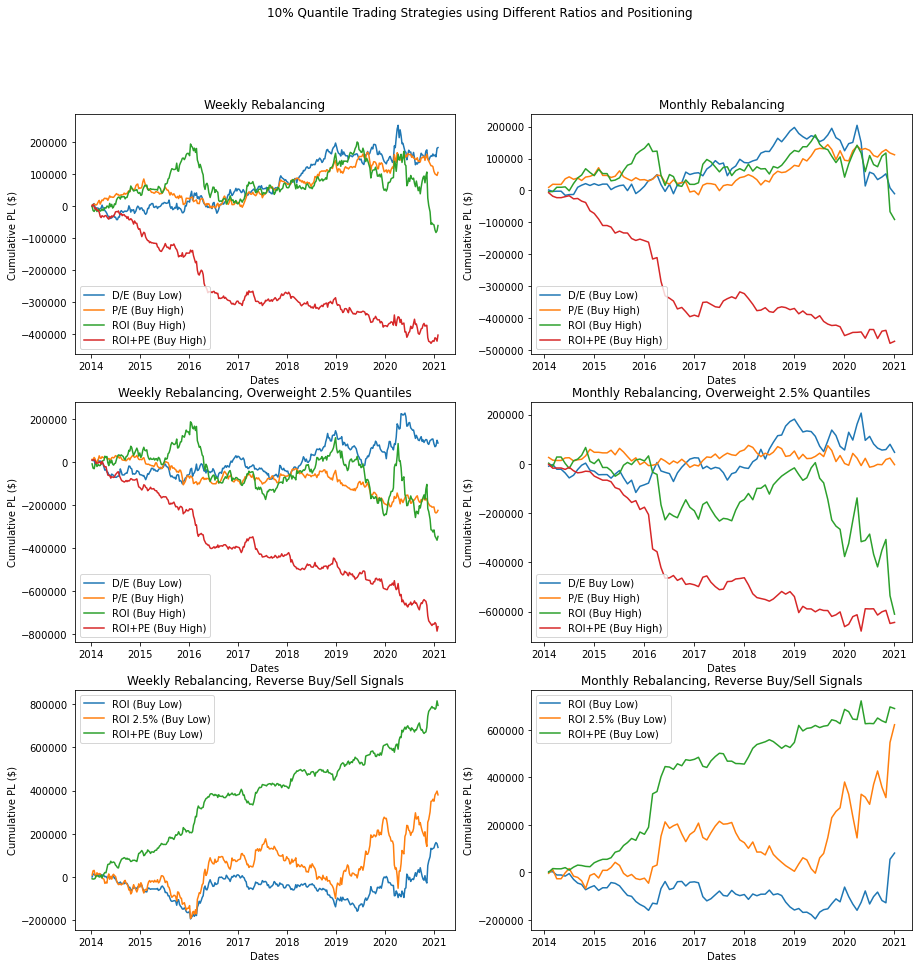

In [65]:
plotme = PL_stats([DE_21,PE_21,ROI_21,ROIPE_21],['DE_21','PE_21','ROI_21','ROIPE_21']).T
plotwe = PL_stats([DE_5,PE_5,ROI_5,ROIPE_5],['DE_5','PE_5','ROI_5','ROIPE_5']).T
plotw2 = PL_stats([DE_5_twotier,PE_5_twotier,ROI_5_twotier,ROIPE_5_twotier],['DE_5_twotier','PE_5_twotier','ROI_5_twotier','ROIPE_5_twotier']).T
plotm2 = PL_stats([DE_21_twotier,PE_21_twotier,ROI_21_twotier,ROIPE_21_twotier],['DE_21_twotier','PE_21_twotier','ROI_21_twotier','ROIPE_21_twotier']).T
plotwn = PL_stats([ROI_5_N,ROI_5_twotier_N,ROIPE_5_twotier_N],['ROI_5_N','ROI_5_twotier_N','ROIPE_5_twotier_N']).T
plotmn = PL_stats([ROI_21_N,ROI_21_twotier_N,ROIPE_21_twotier_N],['ROI_21_N','ROI_21_twotier_N','ROIPE_21_twotier_N']).T
fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(3,2,figsize=(15,15))
l1 = ax1.plot(plotwe.index,plotwe['DE_5_PL_LTD'],label='D/E (Buy Low)')
l2 = ax1.plot(plotwe.index,plotwe['PE_5_PL_LTD'],label='P/E (Buy High)' )
l3 = ax1.plot(plotwe.index,plotwe['ROI_5_PL_LTD'],label='ROI (Buy High)')
l4 = ax1.plot(plotwe.index,plotwe['ROIPE_5_PL_LTD'],label='ROI+PE (Buy High)')
l1 = ax2.plot(plotme.index,plotme['DE_21_PL_LTD'],label='D/E (Buy Low)')
l2 = ax2.plot(plotme.index,plotme['PE_21_PL_LTD'],label='P/E (Buy High)')
l3 = ax2.plot(plotme.index,plotme['ROI_21_PL_LTD'],label='ROI (Buy High)')
l4 = ax2.plot(plotme.index,plotme['ROIPE_21_PL_LTD'],label='ROI+PE (Buy High)')
l1 = ax3.plot(plotw2.index,plotw2['DE_5_twotier_PL_LTD'],label='D/E (Buy Low)')
l2 = ax3.plot(plotw2.index,plotw2['PE_5_twotier_PL_LTD'],label='P/E (Buy High)')
l3 = ax3.plot(plotw2.index,plotw2['ROI_5_twotier_PL_LTD'],label='ROI (Buy High)')
l4 = ax3.plot(plotw2.index,plotw2['ROIPE_5_twotier_PL_LTD'],label='ROI+PE (Buy High)')
l1 = ax4.plot(plotm2.index,plotm2['DE_21_twotier_PL_LTD'],label='D/E Buy Low)')
l2 = ax4.plot(plotm2.index,plotm2['PE_21_twotier_PL_LTD'],label='P/E (Buy High)')
l3 = ax4.plot(plotm2.index,plotm2['ROI_21_twotier_PL_LTD'],label='ROI (Buy High)')
l4 = ax4.plot(plotm2.index,plotm2['ROIPE_21_twotier_PL_LTD'],label='ROI+PE (Buy High)')
l1 = ax5.plot(plotwn.index,plotwn['ROI_5_N_PL_LTD'],label='ROI (Buy Low)')
l2 = ax5.plot(plotwn.index,plotwn['ROI_5_twotier_N_PL_LTD'],label='ROI 2.5% (Buy Low)' )
l3 = ax5.plot(plotwn.index,plotwn['ROIPE_5_twotier_N_PL_LTD'],label='ROI+PE (Buy Low)')
l1 = ax6.plot(plotmn.index,plotmn['ROI_21_N_PL_LTD'],label='ROI (Buy Low)')
l2 = ax6.plot(plotmn.index,plotmn['ROI_21_twotier_N_PL_LTD'],label='ROI 2.5% (Buy Low)' )
l3 = ax6.plot(plotmn.index,plotmn['ROIPE_21_twotier_N_PL_LTD'],label='ROI+PE (Buy Low)')
fig.suptitle('10% Quantile Trading Strategies using Different Ratios and Positioning')
ax1.title.set_text('Weekly Rebalancing')
ax2.title.set_text('Monthly Rebalancing')
ax3.title.set_text('Weekly Rebalancing, Overweight 2.5% Quantiles')
ax4.title.set_text('Monthly Rebalancing, Overweight 2.5% Quantiles')
ax5.title.set_text('Weekly Rebalancing, Reverse Buy/Sell Signals')
ax6.title.set_text('Monthly Rebalancing, Reverse Buy/Sell Signals')
ax1.set_xlabel('Dates')
ax1.set_ylabel('Cumulative PL ($)')
ax1.legend(loc = 'lower left')
ax2.set_xlabel('Dates')
ax2.set_ylabel('Cumulative PL ($)')
ax2.legend(loc = 'lower left')
ax3.set_xlabel('Dates')
ax3.set_ylabel('Cumulative PL ($)')
ax3.legend(loc = 'lower left')
ax4.set_xlabel('Dates')
ax4.set_ylabel('Cumulative PL ($)')
ax4.legend(loc = 'lower left')
ax5.set_xlabel('Dates')
ax5.set_ylabel('Cumulative PL ($)')
ax5.legend(loc = 'upper left')
ax6.set_xlabel('Dates')
ax6.set_ylabel('Cumulative PL ($)')
ax6.legend(loc = 'upper left')

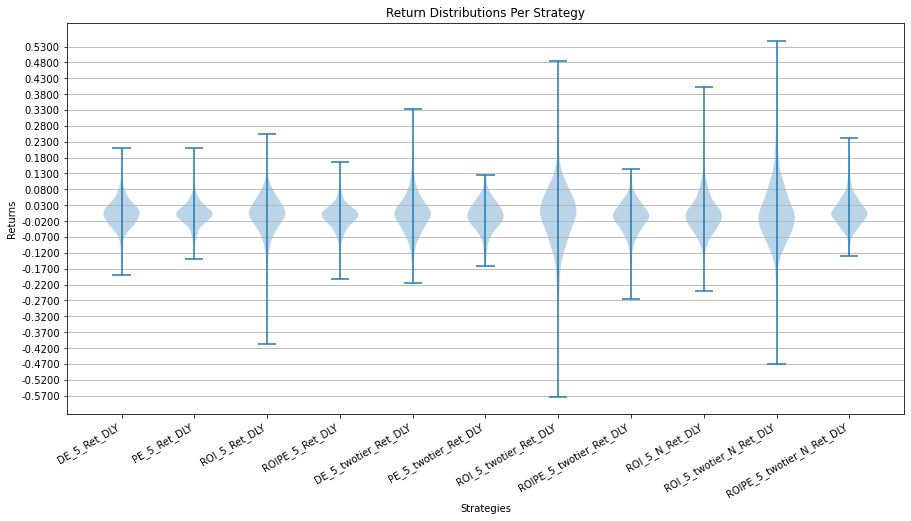

In [538]:
plotviolins(stats(StrategyList_W,StrategyList_WStr,'Retlist'),stats(StrategyList_W,StrategyList_WStr,'Retlist').columns)

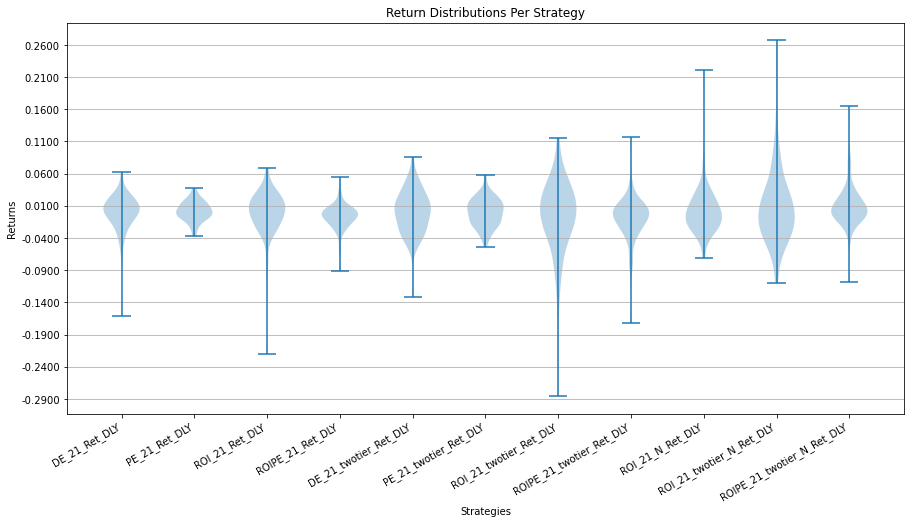

In [539]:
plotviolins(stats(StrategyList_M,StrategyList_MStr,'Retlist'),stats(StrategyList_M,StrategyList_MStr,'Retlist').columns)

#### Statistics and Risk Metrics

When looking at profitability and risk-reward, the two-tier strategy appears to offer the highest Sharpe and Sortino ratios. However, getting the direction of the signal correct is key - the below table shows how the two tier strategies are either very good or very bad performers. Two-tier strategies appear to do especially well in bad times - the Sortino ratios for them are significantly higher than the simple quantile strategies.

##### Return Statistics on Strategies (Annualized):

In [62]:
stats(StrategyList, StrategyListStr, 'Perf').sort_values('Sharpe',ascending=False)

,Mean,Vol,Sharpe,Sortino,Min,Max
ROIPE_5_twotier_N_Ret_DLY,0.010731,0.006829,1.571426,3.138782,-0.002589,0.004810
ROIPE_21_twotier_N_Ret_DLY,0.009533,0.009320,1.022825,1.683940,-0.009003,0.013712
ROI_21_twotier_N_Ret_DLY,0.008620,0.017218,0.500654,1.208201,-0.009102,0.022252
DE_5_Ret_DLY,0.002555,0.006360,0.401834,0.607769,-0.003792,0.004190
ROI_5_twotier_N_Ret_DLY,0.005241,0.013981,0.374884,0.629382,-0.009421,0.010978
PE_21_Ret_DLY,0.001587,0.004561,0.347896,0.543325,-0.003129,0.003114
PE_5_Ret_DLY,0.001478,0.005120,0.288721,0.429931,-0.002769,0.004206
ROI_5_N_Ret_DLY,0.001912,0.008779,0.217741,0.405832,-0.004820,0.008049
DE_5_twotier_Ret_DLY,0.001222,0.008960,0.136388,0.217097,-0.004270,0.006672
ROI_21_N_Ret_DLY,0.001161,0.010496,0.110652,0.262006,-0.005910,0.018387


When looking at skew, kurtosis, and VaR, the below table shows that the monthly strategies tend to be much more risky than the weekly strategies. Weekly strategies allow for more frequent rebalancing, and this data shows that that is beneficial in terms of controlling downside. Another interesting observation is that the ROI strategies show much larger skew - in the case of buying higher ROI, the Skew is noticeably negative and kurtosis is large. ROI itself does seem to be an important indicator, but the data suggests that buying low ROI may be favorable in terms of infrequent but significant surprises, while buying high ROI can set the strategy up for large losses.

##### Additional Return Stats Including Skew, Excess Kurtosis, and VaR (NOT Annualized) in \\$USD

In [63]:
stats(StrategyList, StrategyListStr, 'Stats').sort_values('VaR (Quantile 0.05)')

,Mean,Median,Min,25% Quantile,75% Quantile,Max,$\sigma$,Skewness,Excess Kurtosis,VaR (Quantile 0.05),VaR (Normal)
ROI_21_twotier_PL_DLY,-7177.5498,0.0000,-228270.3586,-25549.8277,20539.1239,93491.6876,50253.3104,-1.5726,4.9082,-83298.3942,-89836.8897
ROIPE_21_twotier_PL_DLY,-7572.2494,-3848.6981,-139443.5389,-17938.9564,5947.3602,90828.3711,27067.8440,-1.2000,7.7851,-58631.7011,-52094.8909
ROI_21_twotier_N_PL_DLY,7317.7546,0.0000,-93586.1320,-18847.6280,26211.1014,232107.4599,50671.7460,1.6329,5.1571,-50051.3727,-76029.8506
DE_21_twotier_PL_DLY,552.3848,527.3378,-110728.8091,-19200.4202,17505.2596,72105.5598,28545.8790,-0.4191,1.8041,-40039.3500,-46401.4078
ROI_21_N_PL_DLY,960.3533,-2492.1792,-58670.2454,-16374.8846,11184.8595,183200.5825,29912.1299,2.7789,15.7154,-33331.8968,-48240.7220
ROI_5_twotier_PL_DLY,-970.4739,559.5363,-112735.4246,-10467.9947,9790.0774,96368.9012,19935.8589,-0.7110,5.5207,-32683.8908,-33762.0436
DE_21_PL_DLY,-119.3085,3770.5746,-135563.8721,-9578.9590,13574.6453,53396.4190,23713.9464,-2.3231,11.9697,-32410.0750,-39125.2792
ROI_21_PL_DLY,-1067.3320,1212.2673,-183560.9427,-12544.5498,15451.7114,57972.3971,30194.2071,-2.8224,15.3724,-31639.0193,-50732.3830
PE_21_twotier_PL_DLY,-36.5049,33.6478,-44944.1144,-13608.6363,13018.2332,48265.3593,18227.7200,0.0076,-0.0871,-30971.7552,-30018.4363
ROIPE_21_PL_DLY,-5550.1434,-4544.7713,-74263.3820,-12259.3070,3178.1859,44546.3469,16290.6047,-0.9608,4.4915,-27971.5262,-32345.8037


##### Drawdown Statistics for Returns (NOT Annualized)

Again, the ROI two-tier strategies are the worst performers. The PE strategies show the lowest drawdowns, including Single Largest Drawdowns. In terms of a "safe" strategy, PE and PE two-tier appear to be the most consistent in delivering low but safe and consistent returns.

In [64]:
stats(StrategyList, StrategyListStr, 'Tail Risk').sort_values('Max Drawdown')

,Expected Shortfall,Expected Shortfall (Normal),Max Drawdown,MDD Start,MDD End,Recovery Date,Single Largest Drawdown,Single Largest Drawdown Date,Recovery period (days)
ROIPE_5_twotier_Ret_DLY,-0.003053,-0.002417,-0.079645,2014-01-16,2021-01-21,None,-0.005292,2020-11-13,NaN
ROI_21_twotier_Ret_DLY,-0.014885,-0.011451,-0.06828,2014-10-31,2021-01-05,None,-0.023831,2020-12-03,NaN
ROIPE_21_twotier_Ret_DLY,-0.00829,-0.006677,-0.067995,2014-02-03,2020-05-06,None,-0.01434,2016-03-04,NaN
ROI_5_twotier_Ret_DLY,-0.005299,-0.004241,-0.054569,2016-01-12,2021-01-21,None,-0.011458,2020-11-13,NaN
ROIPE_21_Ret_DLY,-0.00497,-0.004062,-0.047275,2014-02-03,2020-12-03,None,-0.007615,2016-05-04,NaN
ROIPE_5_Ret_DLY,-0.001993,-0.001721,-0.043578,2014-01-16,2020-12-07,None,-0.004018,2020-11-13,NaN
ROI_5_twotier_N_Ret_DLY,-0.003819,-0.003974,-0.032069,2019-12-24,2020-04-06,2020-08-13,-0.009421,2020-03-09,233
ROI_5_Ret_DLY,-0.003223,-0.002572,-0.027981,2019-06-06,2021-01-13,None,-0.00813,2020-11-13,NaN
PE_5_twotier_Ret_DLY,-0.002251,-0.001996,-0.026824,2014-11-07,2021-01-13,None,-0.003239,2015-11-19,NaN
ROI_21_Ret_DLY,-0.008214,-0.006341,-0.026296,2019-06-06,2021-01-05,None,-0.01831,2020-12-03,NaN


##### Turnover Rates

The below box and whisker plots show the trade turnover per rebalance per strategy. Although this is not important for this particular analysis given zero costs are assumed, this will become a significant factor in further applications. It appears that monthly rebalancing results in less trades per rebalance, which is interesting given one would expect there to be more changes in the make-up over the course of one month than one week. This data suggests that these ratios are very volatile in shorter periods, but ratios tend to come back in line over extended periods of time. This is an important and unexpected observation. For both monthly and weekly strategies, it appears that DE ratios result in the most trades - while all of the other strategies tend to result in the same amount of rebalancing.

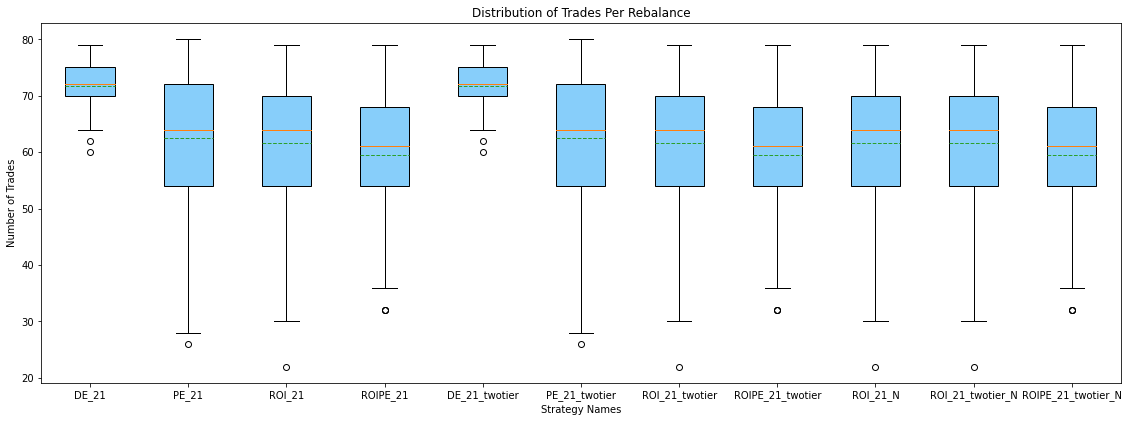

In [249]:
PlotTrades(StrategyList_M,StrategyList_MStr)

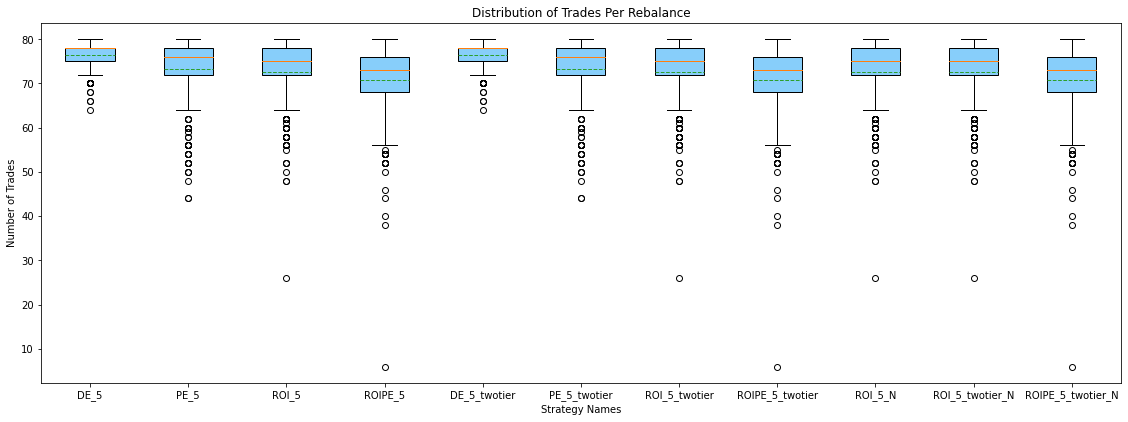

In [250]:
PlotTrades(StrategyList_W,StrategyList_WStr)

###  Conclusion

Overall, it appears that quantile trading can be effective in executing a view that one has using a ratio or parameter of choice. Data sourcing and cleaning was especially painful in this case given the huge amount of data and multiple sources, which can be a significant problem when trying to execute strategies on more esoteric parameters. Creation of the strategy was much more difficult than the algorithm for spread trading as well, given that because of the sheer size of data, it is impossible to simply loop through cell by cell using row operators. Exploring vector calculations further will help to more readily create better trading strategies.

In terms of the strategies analyzed, buying lower the z-scored combination of ROI and PE using weekly rebalancing is the most profitable. This strategy is closely followed by other strategies related to buying lower ROI. The Sharpe and Sortino ratios for these strategies are significantly high as well. The DE ratio did not have any exemplar results, while PE ratio strategies are effective in providing relatively low returns with low risk - the drawdown numbers for PE were consistently lower than for any other strategy.

With regard to further exploration, one parameter that was not experimented with the above analysis was changing the hold-tolerance quantile. Making this very wide would make the portfolio less dynamic and less susceptible to small changes in company performance, while making it more narrow would allow the strategy to update with new "better" companies. Another interesting area to look at would be to see how these strategies perform compared to the market - if we take the Information ratio with respect to the market, how does the performance change? Also, how do these strategies line up against, for example, long short hedge funds which may inevitably doing the same thing. Lastly, considering the impact of trading costs - especially in times of market stress, would be of operational concern.

The results of this strategy support the view that quantile strategies can be effective - choosing the right signal and direction are essential for this to work, but optimizing supporting parameters such as rebalance frequency and potentially holding boundaries can effectively calibrate the strategies as well.